# N-Asset Frontier

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

In [5]:
from scipy.optimize import minimize

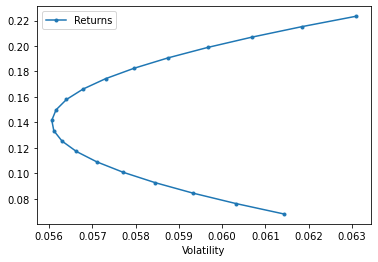

In [6]:
l = ['Games', 'Fin']
erk.plot_ef2(20, er[l], cov.loc[l, l])

In [7]:
# def target_is_met(w, er):
#    return target_return - erk.portfolio_return(w, er)

def minimize_vol(target_return, er, cov):
    '''
    target returns -> weight vector
    '''
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    # set the bounds
    bounds = ((0.0, 1.0),)*n # make n copies of tuples (0.0, 1.0)
    # set the constraints
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - erk.portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

In [8]:
w15 = minimize_vol(0.15, er[l], cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

In [9]:
w15

array([0.47287631, 0.52712369])

In [11]:
# put the def minimize_vol into erk module
w15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])
vol15

0.056163669406706564

In [16]:
def optimal_weights(n_points, er, cov):
    '''
    Generates list of weights to run the optimizer on to minimize the vol
    '''
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights
    
def plot_ef(n_points, er, cov, style='.-'):
    '''
    Plots the N-asset efficient frontier
    '''
    weights = optimal_weights(n_points, er, cov)
    rets = [erk.portfolio_return(w, er) for w in weights]
    vols = [erk.portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        'Returns': rets, 
        'Volatility': vols
        })
    return ef.plot.line(x='Volatility', y='Returns', style=style)

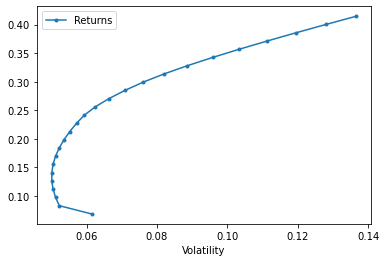

In [17]:
l = ['Smoke', 'Fin', 'Games', 'Coal']
plot_ef(25, er[l], cov.loc[l,l])

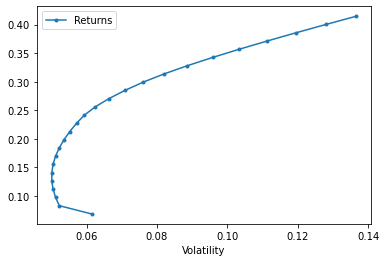

In [18]:
# put the def optimal_weights and plot_ef into erk module
l = ['Smoke', 'Fin', 'Games', 'Coal']
erk.plot_ef(25, er[l], cov.loc[l,l])